In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from torch.optim import SGD
from torch.utils.data import random_split, DataLoader
from imutils import paths
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
def normalizeAndProcessing(img: np.ndarray):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64)),  transforms.Normalize((0, ), (1.0, ))])
    vector = transform(img)
    return vector


In [4]:
def getData(list_dir, threshold):
    data = []
    for img_path in list_dir[:threshold]:
        label_img = img_path.split(os.path.sep)[-1].split('.')[0]
        label = 1
        if label_img == 'cat': label = 0
        img = cv2.imread(img_path)
        normalize_img = normalizeAndProcessing(img)
        data.append([normalize_img, label])
    return data

In [5]:
path_train = 'D:\\dogs-vs-cats\\train'
path_test = 'D:\\dogs-vs-cats\\test1'
list_dir_train = list(paths.list_images(path_train))
list_dir_test = list(paths.list_images(path_test))
train_dataset = getData(list_dir_train, 25000)
train_size = 0.7
test_size = 0.3
training, validation = random_split(train_dataset, [train_size, test_size])
batch_size = 64
train_dataloader = DataLoader(training, batch_size = batch_size, shuffle  = True)
test_dataloader = DataLoader(validation, batch_size = batch_size, shuffle = False)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3))
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3))
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3))
        self.max_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(128 * 6 * 6 , 512)
        self.linear2 = nn.Linear(512, 2)
    def forward(self, x):
        x = self.max_pool(self.activation(self.conv1(x)))
        x = self.max_pool(self.activation(self.conv2(x)))
        x = self.max_pool(self.activation(self.conv3(x)))
        x = x.view(-1, 128 * 6 * 6)
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return x

In [7]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr = 0.01)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (linear1): Linear(in_features=4608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=2, bias=True)
)


In [8]:
max_epochs = 5
train_losses, test_losses, test_accuracy = [], [], []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    total = 0
    correct = 0
    for img, label in train_dataloader:
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    # Evaluate model
    model.eval()
    test_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for img, label in test_dataloader:
            outputs = model(img)
            loss = criterion(outputs, label)
            test_loss += loss.item()
            _, y_hat = torch.max(outputs, 1)
            total += label.size(0)
            correct += (y_hat == label).sum().item()
    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)
    accuracy = correct / total
    test_accuracy.append(accuracy)
    print(f'Epoch {epoch + 1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/5, Train Loss: 0.6926, Test Loss: 0.6921, Test Accuracy: 0.5561
Epoch 2/5, Train Loss: 0.6914, Test Loss: 0.6913, Test Accuracy: 0.5155
Epoch 3/5, Train Loss: 0.6904, Test Loss: 0.6899, Test Accuracy: 0.5636
Epoch 4/5, Train Loss: 0.6885, Test Loss: 0.6885, Test Accuracy: 0.5472
Epoch 5/5, Train Loss: 0.6862, Test Loss: 0.6874, Test Accuracy: 0.5383


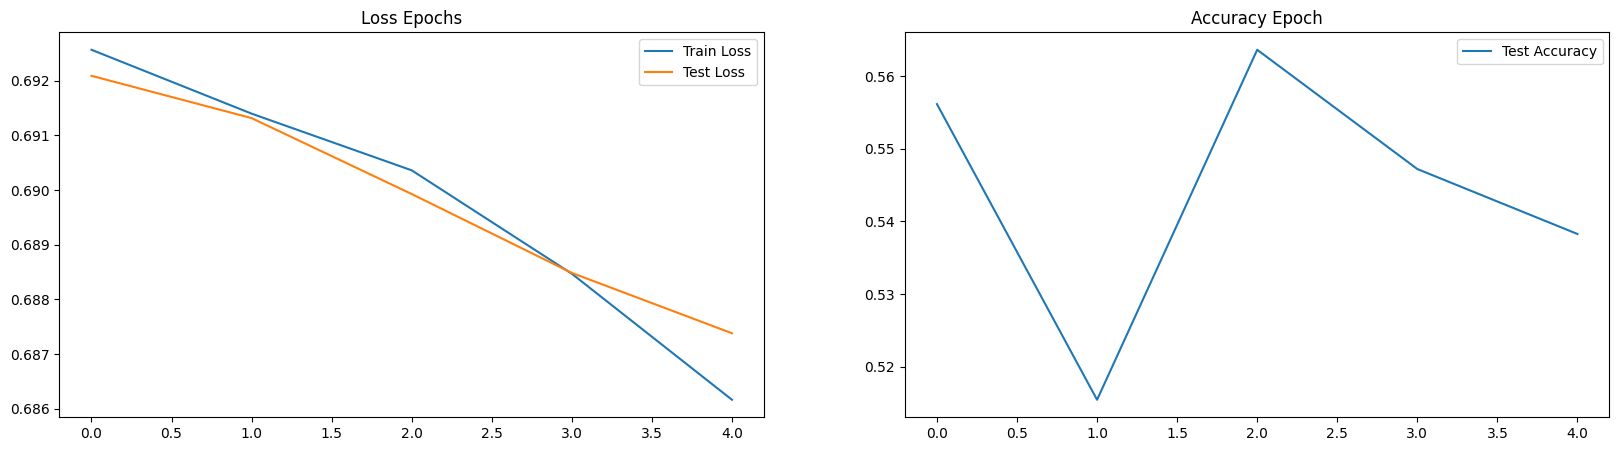

In [9]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()